# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Валинуров".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.
$$ y^{(j)} = \pm1 $$
$$ \frac{\partial L}{\partial w_i} = (\sigma(y^{(j)} g(x^{(j)})) - 1) x_i^{(j)}y^{(j)}$$
К этому нужно прибавлять производную функции регуляризации:

В случае субградиента: $$\frac{\partial L}{\partial w_i} = (\sigma(y^{(j)} g(x^{(j)})) - 1) x_i^{(j)}y^{(j)} + \frac{1}{C}sign(w_i)$$

Cumulative Penalty:  $$u_k=\frac{C}{N}\sum_{t=1}^k\alpha_t$$
$$q_i^k=\sum_{t=1}^k(w_i^{t+1} - w_i^{t+\frac{1}{2}})$$
$$w_i^{k+\frac{1}{2}} = w_i^k + \alpha_k \frac{\partial L}{\partial w_i}\bigg|_{w=w^k}$$
$$if w_i^{k+\frac{1}{2}} > 0: w_i^{k+1}=max(0, w_i^{k+\frac{1}{2}} - (u_k + q_i^{k-1})) $$
$$if w_i^{k+\frac{1}{2}} < 0: w_i^{k+1}=min(0, w_i^{k+\frac{1}{2}} + (u_k - q_i^{k-1})) $$

Если y принимают значения 0 и 1 вместо -1 и +1, то формула принимает вид:
$$ \frac{\partial L}{\partial w_i} = (\sigma(g(x^{(j)})) - y^{(j)}) x_i^{(j)}$$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, debug=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.debug = debug
    
    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-z))
    
    def _gradient_without_reqularization(self, x, y):
        return (self._sigmoid(x.dot(self.w)) - y) * x
    
    def _fit(self, X, y=None, partial=False):
        X = np.c_[np.ones(X.shape[0]), X]
        u_n = 0
        q = np.zeros(X.shape[1])
        w_half = np.empty(X.shape[1])
        if not partial:
            self.w = np.random.uniform(-1./X.shape[1], 1./X.shape[1], X.shape[1])
            
        if self.debug:
            proba = self._sigmoid(X.dot(self.w))
            self.epoch_log = -(y * np.log(proba) + (1 - y) * np.log(1 - proba)).mean()
        
        for n_epoch in xrange(self.max_epoch):
            u_n += self.C / X.shape[0] * self.alpha / (n_epoch + 1)
            for num, i in enumerate(np.random.permutation(X.shape[0])):
                grad = self._gradient_without_reqularization(X[i], y[i])
                w_half = self.w - self.alpha/ float(n_epoch + 1) * grad # типа попытка реализовать cumulative penalty
                self.w[w_half > 0] = np.maximum(0, w_half[w_half > 0] - (u_n + q[w_half > 0]))
                self.w[w_half < 0] = np.minimum(0, w_half[w_half < 0] + (u_n - q[w_half < 0]))
                q += self.w - w_half
                if num % 1000 == 0 and self.debug: # логируем каждую 1000 итерацию
                    proba = self._sigmoid(X.dot(self.w))
                    self.epoch_log = np.append(self.epoch_log, -(y * np.log(proba) + (1 - y) * np.log(1 - proba)).mean())
        return self
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self._fit(X, y)     
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''    
        self._fit(X, y, True)     
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = (np.c_[np.ones(X.shape[0]),X].dot(self.w) > 0).astype(int)
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = self._sigmoid(np.c_[np.ones(X.shape[0]),X].dot(self.w))
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

Полученные веса: coef0=-2.895291, coef1=0.722419, coef2=-0.654627


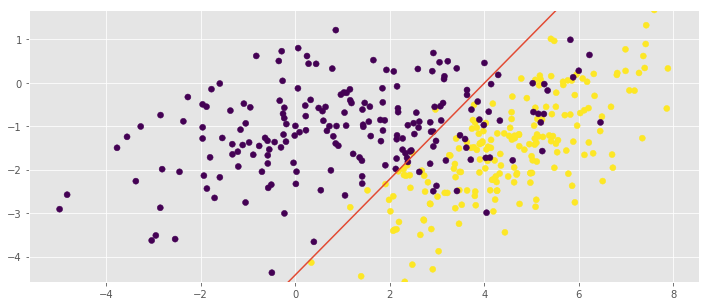

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
plt.scatter(X[:,0], X[:,1], c=y)

model = MySGDClassifier(alpha=0.03, C=1, max_epoch=20)
model.fit(X, y)
xx = np.linspace(X[:,0].min(), X[:,0].max())
yy = -(model.w[0] + model.w[1]*xx) / model.w[2]
plt.plot(xx, yy)
plt.ylim(X[:,1].min(), X[:,1].max());

print "Полученные веса: coef0=%f, coef1=%f, coef2=%f" % tuple(model.w)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [5]:
from sklearn.datasets import make_classification

In [6]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

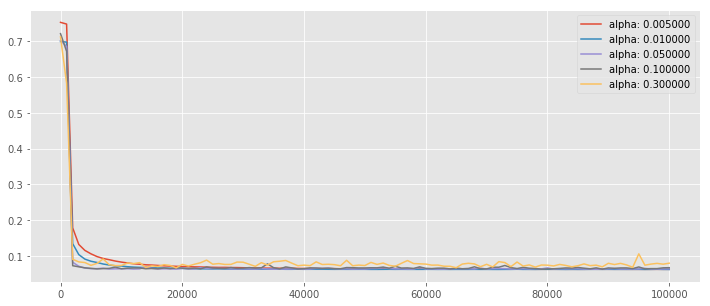

In [7]:
# логируем каждую 1000 итерацию
for alpha in [0.005, 0.01, 0.05, 0.1, 0.3]:
    model = MySGDClassifier(max_epoch=1, C=100, alpha=alpha, debug=True)
    model.fit(X, y)
    plt.plot(np.arange(model.epoch_log.shape[0]) * 1000, model.epoch_log, label='alpha: %f' % alpha)
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [8]:
weights = np.empty((len(np.logspace(3, -3, 10)), X.shape[1] + 1))
for i, c in enumerate(np.logspace(3, -3, 10)):
    model = MySGDClassifier(alpha=0.3, max_epoch=1, C=c)
    model.fit(X, y)
    weights[i] = model.w

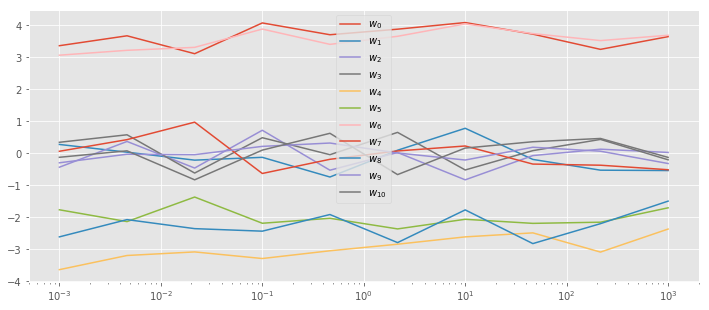

In [9]:
for w_num in range(X.shape[1] + 1):   
    plt.plot(np.logspace(3, -3, 10), weights[:, w_num], label='$w_{%d}$' % w_num)
    plt.xscale('log')
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [10]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
    
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [11]:
df_data.shape

(2000000, 45)

In [12]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [13]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [14]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [15]:
print df_data.opponent_hero_card_id.nunique()
print df_data.player_hero_card_id.nunique()

9
9


In [16]:
player_cards = pd.get_dummies(df_data.player_hero_card_id, prefix='player_hero_cards')
opponent_cards = pd.get_dummies(df_data.opponent_hero_card_id, prefix='opponent_hero_cards')
df_data = pd.concat([df_data, player_cards, opponent_cards], axis = 1)

del df_data['player_hero_card_id']
del df_data['opponent_hero_card_id']

In [17]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [18]:
y = df_data.decision.values
X = df_data.values[:, 1:]

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
model = Pipeline([('scaler', StandardScaler()), ('classifier', MySGDClassifier(max_epoch=1, C=2000, alpha=0.001))])

In [21]:
model.fit(X, y)

/home/denis/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', MySGDClassifier(C=2000, alpha=0.001, debug=False, max_epoch=1))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [22]:
df_test_list = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_test_list.append(pd.read_csv(filepath, sep=','))
    
df_test_data = pd.concat(df_test_list)

In [23]:
df_test_data.shape

(1250000, 45)

In [24]:
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

player_cards = pd.get_dummies(df_test_data.player_hero_card_id, prefix='player_hero_cards')
opponent_cards = pd.get_dummies(df_test_data.opponent_hero_card_id, prefix='opponent_hero_cards')
df_test_data = pd.concat([df_test_data, player_cards, opponent_cards], axis = 1)

del df_test_data['player_hero_card_id']
del df_test_data['opponent_hero_card_id']

X_test = df_test_data.values[:, 1:]

In [25]:
y_test = pd.read_table('deprecated_testLabels.txt', names=['decision'])

In [26]:
y_test.shape

(1250000, 1)

In [27]:
y_test_pred = model.predict_proba(X_test)

In [28]:
from sklearn.metrics import roc_curve, auc

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print roc_auc

0.794848657016
